# exploratory data analysis<a id='3_Exploratory_Data_Analysis'></a>

## contents
* [introduction](#introduction)
* [imports and load](#imports_and_load)
* [exploration](#exploration_start)
    - [check for bias](#bias_check)
        - [bias in race](#race)
        - [type of diabetes](#type)
    - [demographic visualizations](#demo_viz)
    - [demographic readmit ratios](#demo_rat)
    - [admission source and type](#admit_st)
    - [preadmission measurements](#preadmit_metrics)
        - [previous encounters](#prev_enc)
        - [glucose measurements](#glu_meas)
    - [numerical descriptions of admission](#num_)
        - [time in hopsital](#tih)
        - [number of lab procedures](#nlp)
        - [number of procedures](#np)
        - [number of medications](#nm)
        - [number of diagnoses](#nd)
    - [top 3 diagnoses](#dx)
    - [medications](#meds)
- [Wrap-up](#wrapUp)

## introduction<a id='introduction'></a>

The goal of this analysis will be to understand this data more fully.  This exploration will inform modelling decisions and possibly reveal insights itself.  This work will include reviewing distributions, scaling, encoding and testing interactions.  Additional data may be merged during exploration as needed and available.

## imports and load<a id='imports_and_load'></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from scipy.stats import pearsonr
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from gensim.models import Word2Vec
from collections import Counter
import warnings 

warnings.filterwarnings('ignore')
%matplotlib inline

Pip requirements for reproducibility

In [2]:
pip list --format=freeze > requirements-nb2.txt

Note: you may need to restart the kernel to use updated packages.


Start with the output of the data wrangling and confirm load

In [3]:
admissions = pd.read_parquet('../data/interim/notebook1_output.parquet')
print(admissions.shape)
admissions.head()

(101727, 38)


,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,...,pioglitazone,rosiglitazone,acarbose,miglitol,tolazamide,insulin,glyburide-metformin,change,diabetesMed,readmitted
encounter_id,,,,,,,,,,,,,,,,,,,,,
2278392,8222157,Caucasian,Female,[0-10),Other,Other,physicial referral,1,41,0,...,No,No,No,No,No,No,No,No,No,NO
149190,55629189,Caucasian,Female,[10-20),emergency,home,emergency room,3,59,0,...,No,No,No,No,No,Up,No,Ch,Yes,>30
64410,86047875,AfricanAmerican,Female,[20-30),emergency,home,emergency room,2,11,5,...,No,No,No,No,No,No,No,No,Yes,NO
500364,82442376,Caucasian,Male,[30-40),emergency,home,emergency room,2,44,1,...,No,No,No,No,No,Up,No,Ch,Yes,NO
16680,42519267,Caucasian,Male,[40-50),emergency,home,emergency room,1,51,0,...,No,No,No,No,No,Steady,No,Ch,Yes,NO


Take a quick look at the features available.

In [4]:
admissions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101727 entries, 2278392 to 443867222
Data columns (total 38 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   patient_nbr               101727 non-null  int64   
 1   race                      101727 non-null  object  
 2   gender                    101727 non-null  object  
 3   age                       101727 non-null  category
 4   admission_type_id         101727 non-null  category
 5   discharge_disposition_id  101727 non-null  category
 6   admission_source_id       101727 non-null  category
 7   time_in_hospital          101727 non-null  int64   
 8   num_lab_procedures        101727 non-null  int64   
 9   num_procedures            101727 non-null  int64   
 10  num_medications           101727 non-null  int64   
 11  number_outpatient         101727 non-null  int64   
 12  number_emergency          101727 non-null  int64   
 13  number_inpatient    

## exploration<a id='exploration_start'></a>

### check for bias<a id='bias_check'></a>

#### race<a id='race'></a>

As there are demographics present, there is an opportunity to know if any particular group is over or under represented.  Race alone is the first target.  What values are available and what percent of the data does each of these values represent?

The 2000 [US Census](https://www2.census.gov/library/publications/decennial/2000/briefs/c2kbr01-01.pdf) reports a full population racial mix of 75.1% white and 12.3% black.

The American Diabetes Association [ADA](https://diabetes.org/about-us/statistics/about-diabetes#:~:text=Diabetes%20by%20race%2Fethnicity&text=12.1%25%20of%20non%2DHispanic%20blacks,7.4%25%20of%20non%2DHispanic%20whites) reports that 12.1% of  non-hispanic blacks and 7.4% of non-hispanic whites have diabetes diagnoses.  Ethnicity was not captured in this dataset so cannot be tested.

In [5]:
print('unique race values:', admissions.race.unique())
twoRace = admissions[admissions.race != 'Other'].copy()
twoRace_counts = twoRace.race.value_counts()
twoRace_fractions = twoRace.race.value_counts('normalize=True')

adj_white_count = twoRace_counts['Caucasian'] * 7.4
adj_black_count = twoRace_counts['AfricanAmerican'] * 12.1
adj_total = adj_white_count + adj_black_count
adj_white_perc = adj_white_count / adj_total
adj_black_perc = adj_black_count / adj_total
print('expected white fraction:', adj_white_perc)
print('observed white fraction:', twoRace_fractions['Caucasian'])
print('expected black fraction:', adj_black_perc)
print('observed black fraction:', twoRace_fractions['AfricanAmerican'])

unique race values: ['Caucasian' 'AfricanAmerican' 'Other']
expected white fraction: 0.7078017567818881
observed white fraction: 0.798421378564756
expected black fraction: 0.29219824321811194
observed black fraction: 0.201578621435244


To make this dataset unbiased, observations with a race value of "Caucasian" should make up ~71% of all observations.  The number of observations over that can be removed at random.

In [6]:
np.random.seed(42)
count_black = twoRace.race.value_counts()['AfricanAmerican']
count_white = twoRace.race.value_counts()['Caucasian']
white_to_remove = int(count_white - (count_black / 0.29 - count_black ))
raceWhite = twoRace[twoRace['race'] == 'Caucasian']
raceWhite = raceWhite.sample(raceWhite.shape[0] - white_to_remove)
raceBlack = twoRace[twoRace['race'] == 'AfricanAmerican']
twoRace = pd.concat( [raceBlack, raceWhite])
twoRace.race.value_counts('normalize=True')

Caucasian          0.710004
AfricanAmerican    0.289996
Name: race, dtype: float64

#### type of diabetes<a id='type'></a>

From here, statistics vary widely on prevalance of type 1 and type 2 diabetes by gender and age.  In general, males are more likely to have diabetes than females, but the gap between the sexes is smaller for type 1.  This dataset does contain the first 3 diagnoses for each admission.  ICD9 codes for diabetes start with 250.

In [7]:
twoRace[~(twoRace['diag_1'].str.contains('250')) &
        ~(twoRace['diag_2'].str.contains('250')) & 
        ~(twoRace['diag_3'].str.contains('250')) 
       ].shape[0] / twoRace.shape[0] 

0.6218346545866364

Unfortunately, 62% of the observations here don't have any diabetes type diagnoses codes included.  Demographic bias corrections end here.

### demographic visualization <a id='demo_viz'></a>

<Figure size 640x480 with 0 Axes>

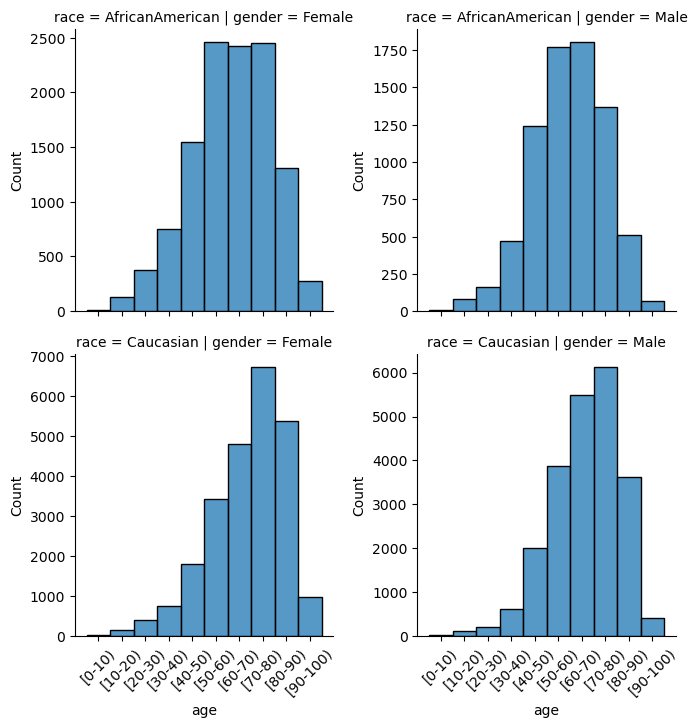

In [8]:
twoRace['age'] = pd.Categorical(twoRace['age'], ['[0-10)', '[10-20)', '[20-30)', '[30-40)', 
    '[40-50)', '[50-60)', '[60-70)', '[70-80)', '[80-90)', '[90-100)',])

plt.clf()

g = sns.FacetGrid(
    twoRace,
    col='gender',
    row='race',
    height=3.5,
    sharey=False
).map(sns.histplot, 'age')

for axes in g.axes.flat:
    for label in axes.get_xticklabels():
        label.set_rotation(45)

plt.show()

These distributions show that the various demographic combinations remaining in the dataset are well represented.  How are these combinations related to the readmission variable?  For this, I'll only be concerned with whether or not readmission happened and not whether or not in happened within 30 days.  I'll look at the readmit rate for each race, gender, age group combination.

<Figure size 640x480 with 0 Axes>

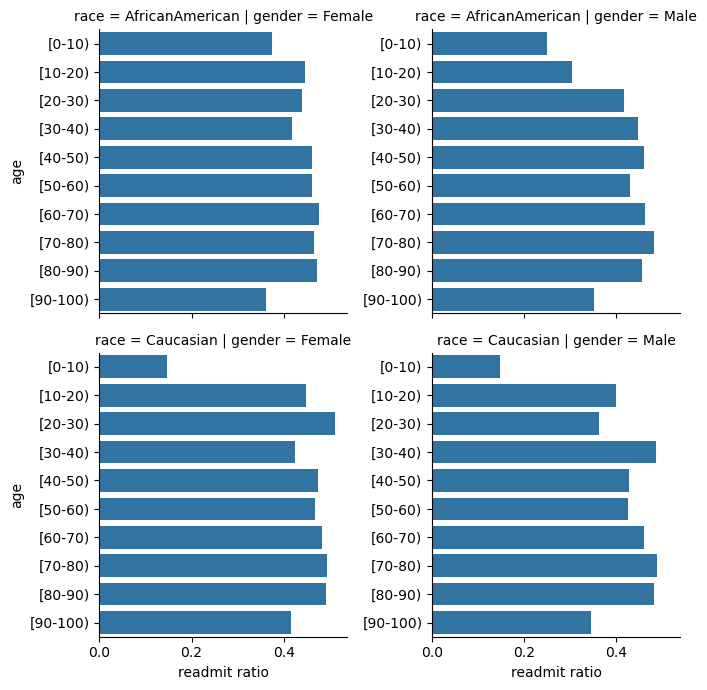

In [9]:
readmitMapping = {'NO': 0, '>30': 1, '<30': 1}
twoRace['readmitBinary'] = twoRace['readmitted'].replace(to_replace=readmitMapping)
demographic_readmit_mean = twoRace.groupby(['race','age','gender'])\
                           .agg([np.mean])['readmitBinary']\
                           .reset_index()

plt.clf()
g = sns.FacetGrid(
    demographic_readmit_mean,
    col='gender',
    row='race',
    height=3.5,
    sharey=False
).map(sns.barplot, 'mean', 'age')

[axes.set_xlabel('readmit ratio') for axes in g.axes.flat]

plt.show()

### demographic readmit ratios <a id='demo_rat'></a>

There are 2 notable items here.  
1. The 0-10 age group is very different between races
3. The 90-100 group has a lower ratio than most other age groups for each race/gender combination.

I suspect both of these can be explained with a small sample size

In [10]:
demographic_counts = twoRace.groupby(['age'])['patient_nbr'].count()
demographic_counts = demographic_counts.to_frame().reset_index()
demographic_counts[(demographic_counts['age'] == '[0-10)') | 
                   (demographic_counts['age'] == '[90-100)')]

,age,patient_nbr
0,[0-10),98
9,[90-100),1735


The small sample idea does hold for the 0-10 age group, but not the 90-100.  Its possible that the 90-100 age group expires during the admission more often than the others.  

In [11]:
twoRace['discharge_disposition_id'].unique()

['home', 'snf', 'Other', 'home health']
Categories (4, object): ['home', 'Other', 'snf', 'home health']

Expiration would fit into the 'Other' category, but so would transferred, etc.  Being discharged to a skilled nursing facility (SNF) or home health could also explain the lack of readmission as these would help with adherence to medical advice given at discharge.

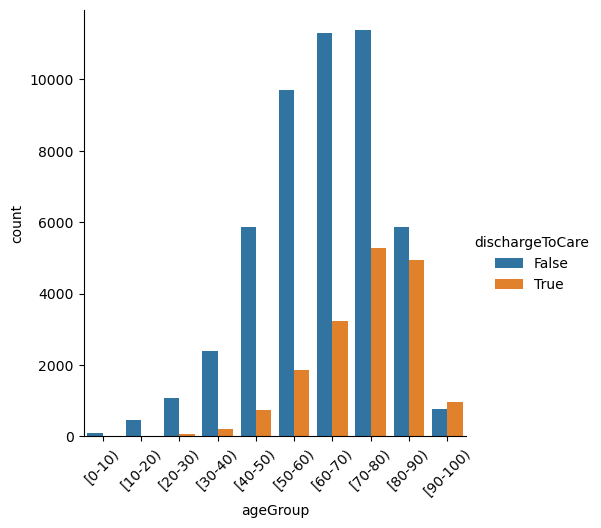

In [12]:
discharge_age_counts = twoRace.groupby(['age','discharge_disposition_id'])['patient_nbr'].count()
discharge_age_counts = discharge_age_counts.to_frame().reset_index()

discharge_age_counts.columns = ['ageGroup','dischargeToCare','count']
to_replace = {'Other': False, 'home': False, 'home health': True, 'snf': True}
discharge_age_counts['dischargeToCare'] = discharge_age_counts['dischargeToCare'].replace(to_replace)
discharge_age_counts = discharge_age_counts.groupby(['ageGroup','dischargeToCare'])['count'].sum()
discharge_age_counts = discharge_age_counts.to_frame().reset_index()

_ = sns.catplot(data=discharge_age_counts
    , x='ageGroup' 
    , y='count' 
    , hue='dischargeToCare'
    , kind='bar'
)
plt.xticks(rotation=45)

plt.show()

The 90-100 age group is the only one where a patient is discharged to care more often than not.  The ratio of discharged to care vs not also increases with age after 30.  What does that look like?

<Axes: xlabel='ageGroup', ylabel='value'>

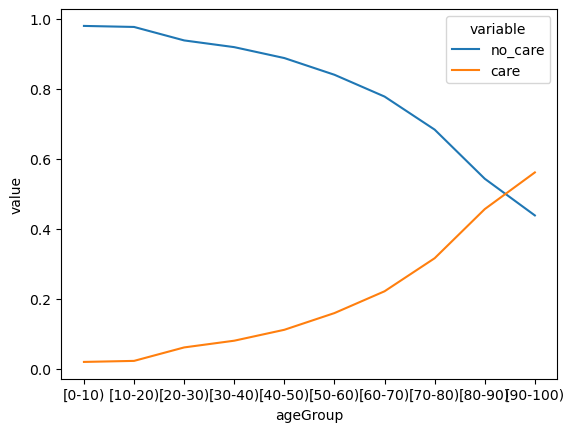

In [13]:
ratios = discharge_age_counts['count'] / \
         discharge_age_counts.groupby('ageGroup')['count'].transform('sum')
no_care = ratios[::2].to_frame().reset_index().drop(columns='index')
care = ratios[1::2].to_frame().reset_index().drop(columns='index')

age_ratios = pd.concat([no_care, care], axis=1)
age_ratios.columns=['no_care', 'care']
age_ratios['ageGroup'] = discharge_age_counts['ageGroup'].unique()

sns.lineplot(data=pd.melt(age_ratios, ['ageGroup']), x='ageGroup', y='value', hue='variable')


This is looking like a good candidate for a new feature.  Does it have a relationship to readmitted?

In [14]:
twoRace['DischargedToCare'] = twoRace['discharge_disposition_id'].replace(to_replace).astype(bool)

In [15]:
def chi2pvalue (rows, columns):
    contingency = pd.crosstab(rows, columns)
    _, p, _, _ = chi2_contingency(contingency)
    return p
    

In [16]:
chi2pvalue(twoRace.readmitted, twoRace.DischargedToCare)

9.39262946259018e-72

It does and this new feature will replace the discharge_disposition_id

In [17]:
twoRace = twoRace.drop(['discharge_disposition_id'], axis=1)

### admission source and type <a id='admit_st'></a>

These variables seem potentially redundant.  I will take a look at the frequency of combinations of their values.

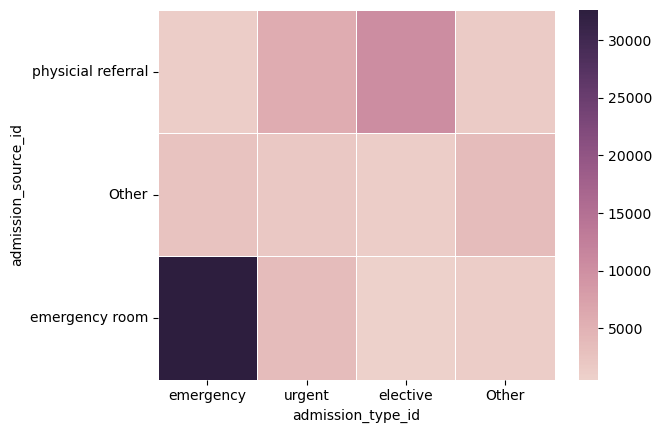

In [18]:
crosstab = pd.crosstab(twoRace['admission_source_id'], twoRace['admission_type_id'])
sns.heatmap(crosstab, cmap=sns.cubehelix_palette(as_cmap=True), yticklabels=True, linewidths=0.5)
plt.yticks(rotation=0)
plt.show()

The first item that stands out is that physical referral should be physician referral

In [19]:
twoRace['admission_source_id'] = twoRace['admission_source_id'].cat.rename_categories({'physicial referral': 'physician referral'})
twoRace.admission_source_id.unique()

['emergency room', 'Other', 'physician referral']
Categories (3, object): ['physician referral', 'Other', 'emergency room']

The next item that stands out is that these 2 look to have a strong association and are possibly redundant.  

Because they are so closely related, I will compare simple logisitic regression models run with the readmitted binary variable and each of these variables independently as well as together to judge the value.  First, I need to encode them.

In [20]:
twoRace.admission_type_id = twoRace.admission_type_id.astype('category')
twoRace.admission_source_id = twoRace.admission_source_id.astype('category')

AdmissionFeatureSelection = twoRace[['admission_type_id','admission_source_id','readmitBinary']].copy()

encoder = OneHotEncoder(drop='first')
encoded = encoder.fit_transform(AdmissionFeatureSelection[['admission_type_id','admission_source_id']])

afs_encoded = pd.DataFrame(encoded.toarray(), columns=encoder.get_feature_names_out())
afs_encoded['readmitBinary'] = AdmissionFeatureSelection['readmitBinary'].values
afs_encoded

,admission_type_id_elective,admission_type_id_emergency,admission_type_id_urgent,admission_source_id_emergency room,admission_source_id_physician referral,readmitBinary
0,0.0,1.0,0.0,1.0,0.0,0
1,0.0,1.0,0.0,1.0,0.0,1
2,0.0,0.0,1.0,0.0,0.0,1
3,1.0,0.0,0.0,0.0,0.0,1
4,0.0,1.0,0.0,1.0,0.0,0
...,...,...,...,...,...,...
66220,0.0,0.0,0.0,0.0,0.0,1
66221,0.0,1.0,0.0,1.0,0.0,0
66222,0.0,0.0,1.0,1.0,0.0,0
66223,0.0,0.0,1.0,0.0,1.0,0


Then create a function to do the regression and return a single metric. 

In [21]:
def simple_logreg (x, y):
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

    logreg = LogisticRegression()
    logreg.fit(x_train, y_train)
    y_pred = logreg.predict(x_test)

    label_and_weight = dict(zip(x.columns, logreg.coef_[0]))

    return accuracy_score(y_test, y_pred), label_and_weight

In [22]:
y = afs_encoded.readmitBinary

admission_type_x = afs_encoded.loc[:, afs_encoded.columns.str.contains('type')]
print(admission_type_x.shape)
simple_logreg(admission_type_x, y)

(66225, 3)


(0.5302289062028145,
 {'admission_type_id_elective': -0.3420897343455047,
  'admission_type_id_emergency': -0.07997740548052241,
  'admission_type_id_urgent': -0.11144173362381765})

In [23]:
admission_source_x = afs_encoded.loc[:, afs_encoded.columns.str.contains('source')]
print(admission_source_x.shape)
simple_logreg(admission_source_x, y)

(66225, 2)


(0.5302289062028145,
 {'admission_source_id_emergency room': 0.40175726869069284,
  'admission_source_id_physician referral': 0.16698493594568198})

In [24]:
both = afs_encoded.iloc[:, :-1]
simple_logreg(both, y)

(0.5377785830766443,
 {'admission_type_id_elective': -0.44556787850468826,
  'admission_type_id_emergency': -0.44412222593173234,
  'admission_type_id_urgent': -0.2737029830842074,
  'admission_source_id_emergency room': 0.5874350140854427,
  'admission_source_id_physician referral': 0.2923791253685427})

As the model using both the admission type and source is more accurate, both will be left in place.  It is also interesting that an emergency admission type means a patient is less likely to be readmitted than an emergency department source.  In hindsight, this is likely because trauma injuries would come through the emergency room and create an emergency admission with a low chance of readmission.

### preadmission measurements <a id="preadmit_metrics"></a>

#### previous encounters <a id="prev_enc"></a>

Details about the patient's interactions with providers in the year before their admission may contain interesting information.  The variables that describe this are num_outpatient, num_emergency, and num_inpatient.  I will start this exploration with histograms to look at the distribution of these variables.

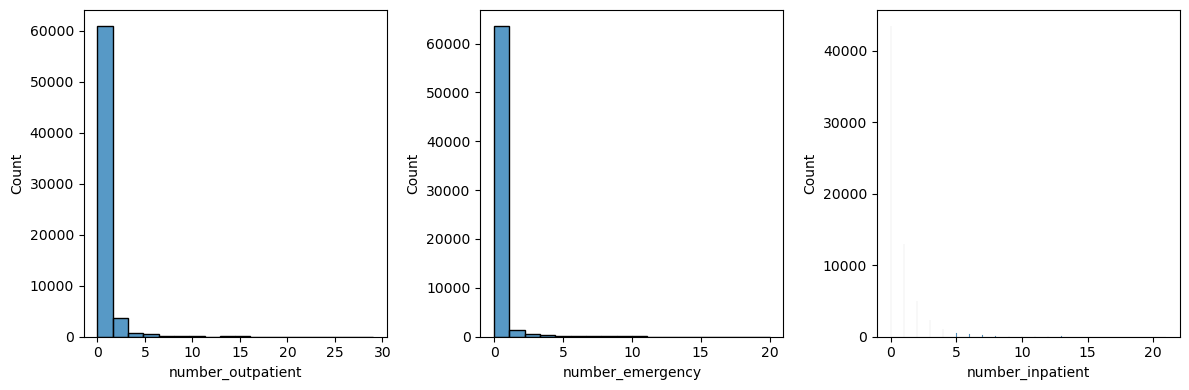

In [25]:
fig, ax = plt.subplots(1, 3, figsize=(12,4))

sns.histplot(twoRace['number_outpatient'], ax=ax[0])
sns.histplot(twoRace['number_emergency'], ax=ax[1])
sns.histplot(twoRace['number_inpatient'], ax=ax[2])

plt.tight_layout()
plt.show()


For all 3 variables, the majority of oberservations have 0 encounters.  These would be better suited as boolean categorical types indicating if the patient had that type of encounter in the previous year or not.  

In [26]:
twoRace['outpatientTF'] = twoRace.number_outpatient.astype(bool)
twoRace['emergencyTF'] = twoRace.number_emergency.astype(bool)
twoRace['inpatientTF'] = twoRace.number_inpatient.astype(bool)

twoRace = twoRace.drop(['number_outpatient','number_emergency','number_inpatient'], axis=1)

In [27]:
[f'{x}: {twoRace[x].mean()}' for x in ['outpatientTF','emergencyTF','inpatientTF']]

['outpatientTF: 0.16288410721026803',
 'emergencyTF: 0.11630049075122688',
 'inpatientTF: 0.34322385805964517']

#### glucose measurements<a id="glu_meas"></a>

A1Cresult and max_glu_serum speak to how well the patient's diabetes is managed.  These could be interesting as well.

In [28]:
print(twoRace.A1Cresult.astype('category').value_counts(), '\n\n')
print(twoRace.max_glu_serum.astype('category').value_counts())

None    55216
>8       5371
Norm     3269
>7       2369
Name: A1Cresult, dtype: int64 


None    62955
Norm     1612
>200      877
>300      781
Name: max_glu_serum, dtype: int64


These values were sparesely captured and categorized into broad categories.  Unfortunately, these will need to be dropped.

In [29]:
twoRace = twoRace.drop(['A1Cresult','max_glu_serum'], axis=1)

### numerical descriptions of admission <a id="num_"></a>

The next set of variables to explore are the different counts of occurences in during the initial admission.  These include time_in_hospital, num_lab_procedures, num_procedures, num_medications, and num_diagnoses.  At a high level, these describe the number of interventions performed during the admission.

In [30]:
encounter_attributes = twoRace[['time_in_hospital',
                                'num_lab_procedures',
                                'num_procedures',
                                'num_medications',
                                'number_diagnoses']].copy()

I would first like to see the distribution of these variables.  I will use a box plot and histogram for this.

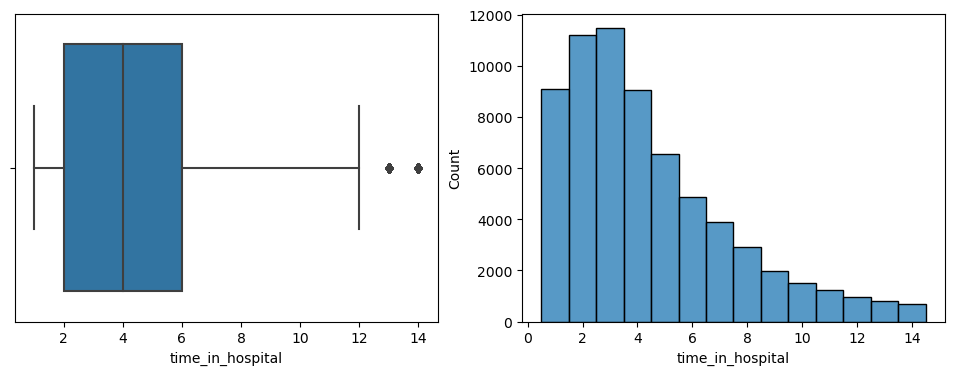

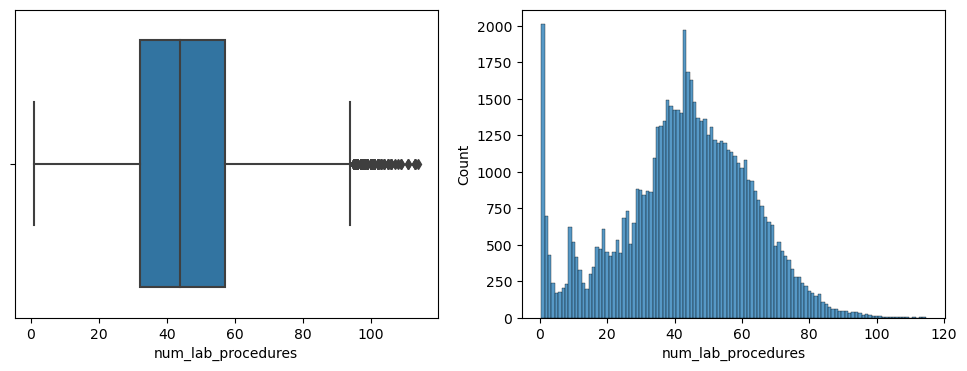

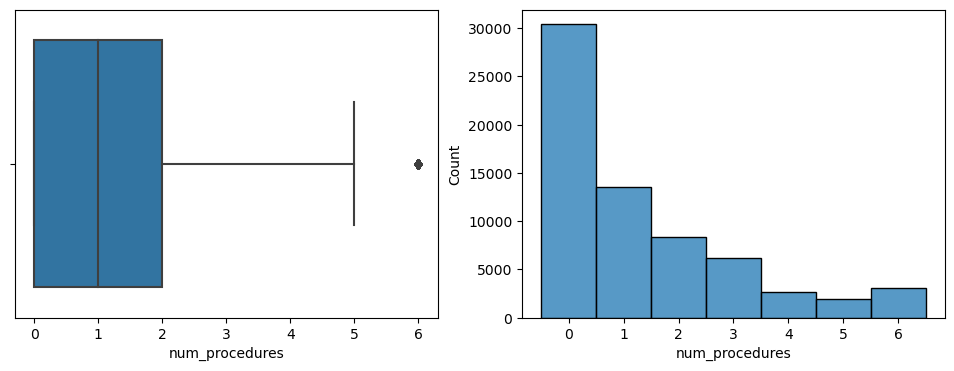

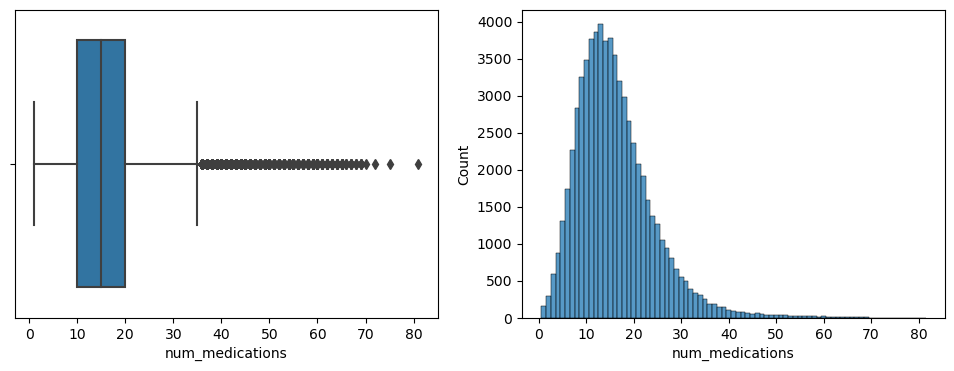

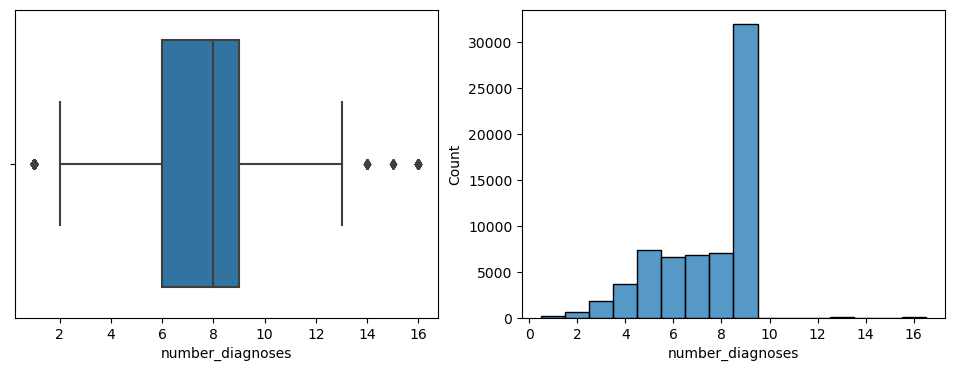

[None, None, None, None, None]

In [31]:
def box_and_hist_int (array):

    bins = np.arange(array.min() - 0.5, array.max() + 1.5, 1)
    
    fig, ax = plt.subplots(1, 2, figsize=(12,4))

    sns.boxplot(x=array, ax=ax[0], showfliers=True)
    sns.histplot(array, ax=ax[1], bins=bins)

    plt.show()
    
    return

[box_and_hist_int(encounter_attributes[col]) for col in encounter_attributes.columns]

I will make notes on what to explore next for each variable individually.  I will define outliers as outside of the right most boxplot whisker (75th perctile + 1.5 x the Interquartile range).

<ul style="margin-bottom: 10px;">
    <li>time_in_hopsital</li>
    <ul>
        <li>there are no zeroes</li>
        <li>the distribution looks uniform</li>
        <li>there are outliers that will need to be examined</li>
    </ul>
</ul>

<ul style="margin-bottom: 10px;">
    <li>num_lab_procedures</li>
    <ul>
        <li>there are no zeroes</li>
        <li>something strange is happening at the value 1</li>
        <li>the distribution looks nearly normal, except for a long right tail and a large count of "1"s</li>
        <li>there are many outliers in the long right tail</li>
    </ul>
</ul>

<ul style="margin-bottom: 10px;">
    <li>num_procedures</li>
    <ul>
        <li>many of the observations have a value of 0</li>
        <li>the distribution looks uniform</li>
        <li>there are outliers that need a closer look</li>
    </ul>
</ul>    
    
<ul style="margin-bottom: 10px;">
    <li>num_medications</li>
    <ul>
        <li>there are no zeroes</li>
        <li>the distribution looks nearly normal, except for the long right tail</li>
        <li>there are many outliers in the right tail</li>
    </ul>
</ul>  

<ul style="margin-bottom: 10px;">
    <li>number_diagnoses
    <ul>
        <li>there are no zeroes</li>
        <li>the distribution follows no pattern</li>
        <li>the count of observations with a value of 9 is interesting</li>
        <li>there will be a few outliers to examine.</li>
    </ul>
</ul> 

#### time_in_hospital<a id="tih"></a>

This variable represents the number of days in a patient's admission.  Length of stay is a valuable metric for any hospital based analyses and the uniformity of the right tail in the histogram means it would be appropriate to leave any values deemed outliers by the Q3 + 1.5xIQR definition in place.

#### num_lab_procedures<a id="nlp"></a>

I first want to make sure that I read the plot correctly and there are no observations with a value of zero in this variable.

In [32]:
focused_variable = encounter_attributes.num_lab_procedures
(focused_variable == 0).sum()

0

There are no observations with a value of 0.  

The next step is to address the observations with a value of 1.  It seems highly unlikely that an inpatient encounter would result in only 1 lab test.  There isn't anything in the [documentation for the dataset](https://archive-beta.ics.uci.edu/dataset/296/diabetes+130+us+hospitals+for+years+1999+2008) that would explan this.  Its possible there is something in the data.  To explore this, I will create a new binary variable indicating if the observation had 1 lab procedure or more than 1.

In [33]:
one_lab_procedure = np.where(focused_variable == 1, True, False)
pd.DataFrame(one_lab_procedure).value_counts()

False    64215
True      2010
dtype: int64

It is possible that the new one_lab_procedure is correlated to one of the other variables or values.  I will look for this by reviewing the correlation coefficient between one_lab_procedure and the other variables, using one hot encoding for categorical variables.  Diag_1, 2 and 3 will not be included yet as they all have many levels.  These variables will be compared against one_lab_procedure in their section.

In [34]:
numerics = ['time_in_hospital','num_procedures','num_medications','number_diagnoses',
            'DischargedToCare', 'outpatientTF','emergencyTF', 'inpatientTF']

need_dummies = ['race','gender','age','admission_type_id','admission_source_id',
                'metformin','repaglinide','nateglinide','chlorpropamide', 'glimepiride', 
                'glipizide','glyburide','tolbutamide', 'pioglitazone', 'rosiglitazone', 
                'acarbose','miglitol','tolazamide', 'insulin', 'glyburide-metformin', 
                'change','diabetesMed']

encoded = encoder.fit_transform(twoRace[need_dummies])
corr_df = pd.DataFrame(encoded.toarray(), columns=encoder.get_feature_names_out(), index=twoRace.index)
corr_df = pd.concat([corr_df, twoRace[numerics]], axis=1)
correlated_features = {}

for var in corr_df.columns:
    correlation, p_value = pearsonr(corr_df[var], one_lab_procedure)
    if abs(correlation) > 0.5:
        correlated_features[var] = (correlation, p_value)

correlated_features        

{}

No other variable has more than a 0.5 correlation with one_lab_procedure.  This variable will be added to the dataset and the observations with num_lab_procedures = 1 will have this value changed to other values, sampled randomly from the distribution of the rest of the values.

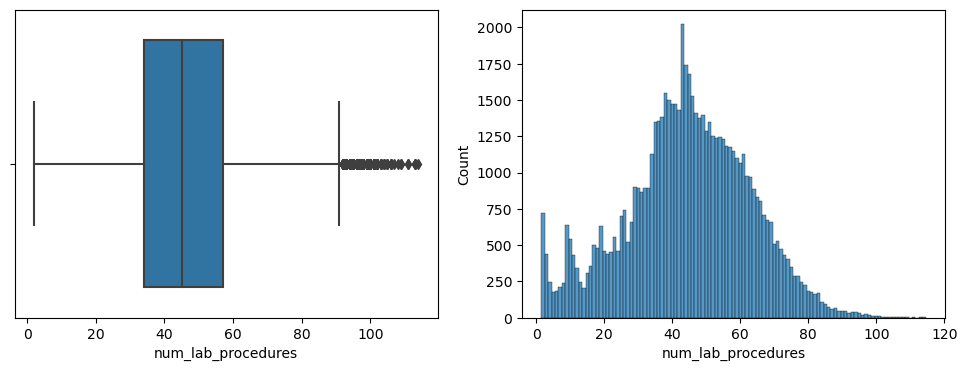

In [35]:
not_one = focused_variable[focused_variable != 1]
count_of_ones = (focused_variable == 1).sum()

new_values = np.random.choice(not_one, size=count_of_ones)

# Replace the 1's in 'num_lab_procedures' with the random values
focused_variable[focused_variable == 1] = new_values

box_and_hist_int(focused_variable)

This variable has maintained its distribution without 1s and the observations with a true value of 1 have been labeled.  Next, the outliers in the right tail need to be treated.  Would it be appropriate to reassign all high outliers to the value of the right whisker (Q3 + 1.5*IQR)?

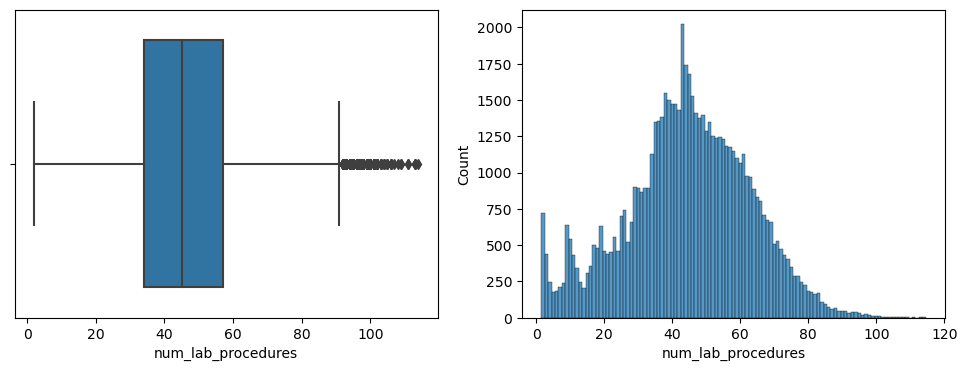

       num_lab_procedures
count        66225.000000
mean            44.537652
std             18.245130
min              2.000000
25%             34.000000
50%             45.000000
75%             57.000000
max            114.000000


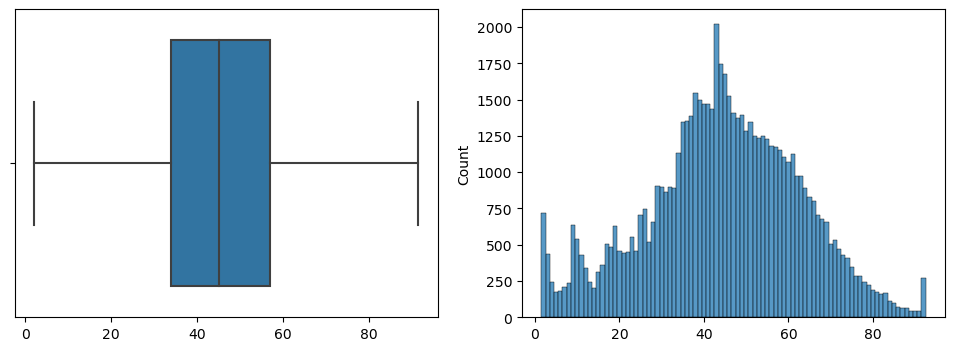

                  0
count  66225.000000
mean      44.517388
std       18.187949
min        2.000000
25%       34.000000
50%       45.000000
75%       57.000000
max       91.500000

right whisker value: 91.5


In [36]:
def iqr_info(data):

    right_whisker = np.percentile(data, 75) + 1.5 * (np.percentile(data, 75) - np.percentile(data, 25))
    reassigned = np.where(data > right_whisker, right_whisker, data)
    box_and_hist_int(data)
    print(pd.DataFrame(data).describe())
    box_and_hist_int(reassigned)
    print(pd.DataFrame(reassigned).describe())
    print(f'\nright whisker value: {right_whisker}')

iqr_info(focused_variable)

In this case, reassigning the outliers to the right whisker value has little impact on the shape of this variable and any information lost would be offset by removing the undue weight of the outliers.  This variable is an integer and to maintain that, 92 will be used for the max value.

In [37]:
focused_variable = np.where(focused_variable > 92, 92, focused_variable)
twoRace['num_lab_procedures'] = focused_variable.copy()
twoRace['one_lab_procedure'] = one_lab_procedure.copy()

#### num_procedures<a id="np"></a>

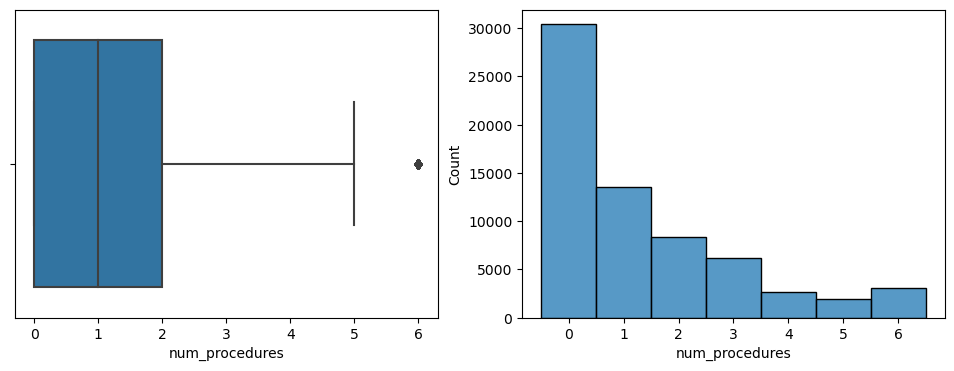

In [38]:
box_and_hist_int(twoRace['num_procedures'])

As expected, this variable should remain untouched.  The small range of values and uniformity should model well.

#### num_medications<a id="nm"></a>

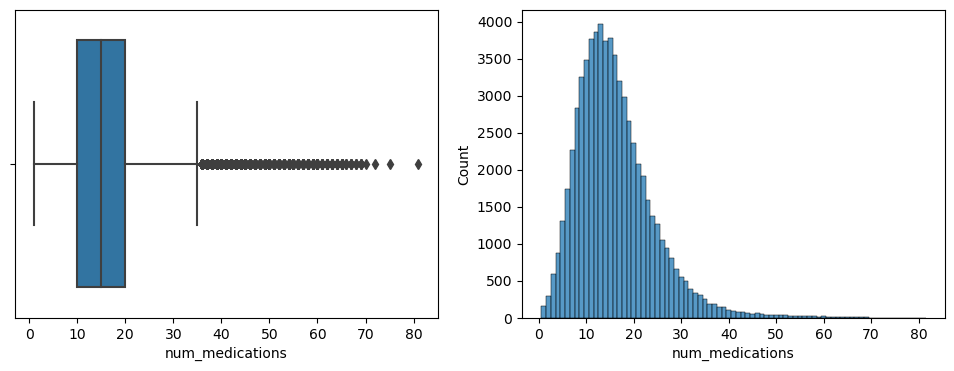

In [39]:
focused_variable = twoRace['num_medications'].copy()
box_and_hist_int(focused_variable)

This is very nearly a textbook normal distribution, except for the very long right tail.  Would it be appropriate to pull all of the higher values down to the outer whisker?

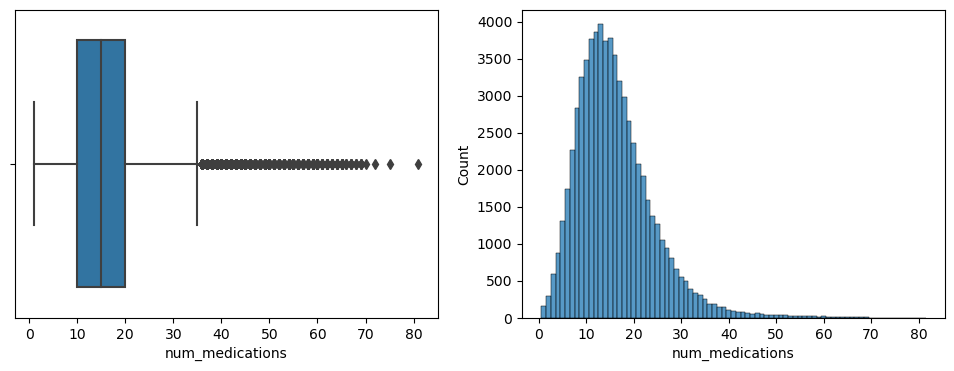

       num_medications
count     66225.000000
mean         16.023873
std           8.086132
min           1.000000
25%          10.000000
50%          15.000000
75%          20.000000
max          81.000000


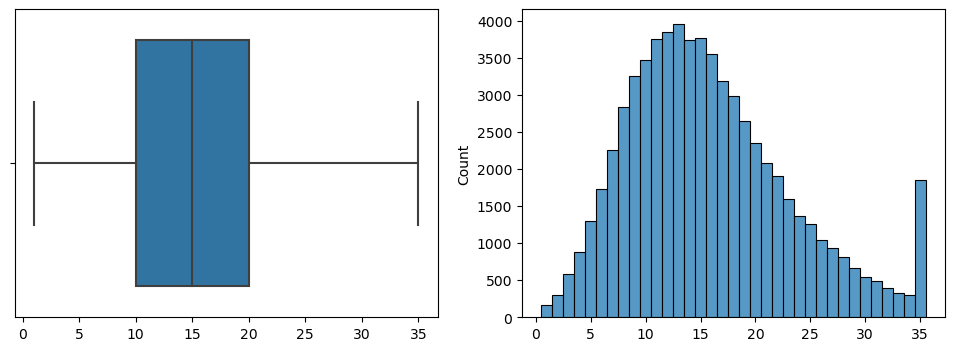

                  0
count  66225.000000
mean      15.817229
std        7.374946
min        1.000000
25%       10.000000
50%       15.000000
75%       20.000000
max       35.000000

right whisker value: 35.0


In [40]:
iqr_info(focused_variable)

This seems passable, but it does change the mean and standard deviation significantly.  Would a log transformation be more appropriate?

<Axes: xlabel='num_medications', ylabel='Count'>

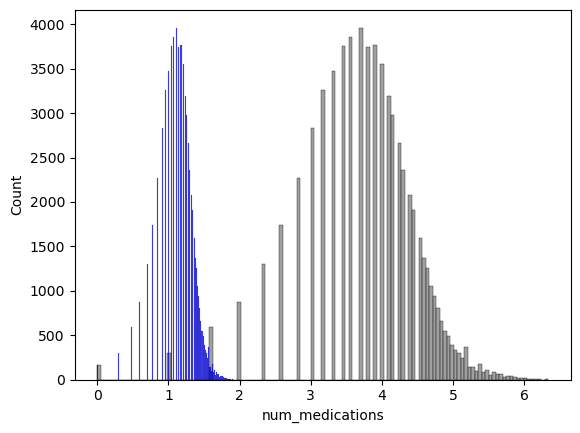

In [41]:
fv_log2 = np.log2(focused_variable)
sns.histplot(fv_log2, color='grey')
fv_log10 = np.log10(focused_variable)
sns.histplot(fv_log10, color='blue')

The log10 transformation results in a more uniform distribution with fewer outliers and seems like the best way to handle the long right tail of num_medications.

In [42]:
twoRace['num_medications'] = np.log10(fv_log10)

#### number_diagnoses<a id="nd"></a>

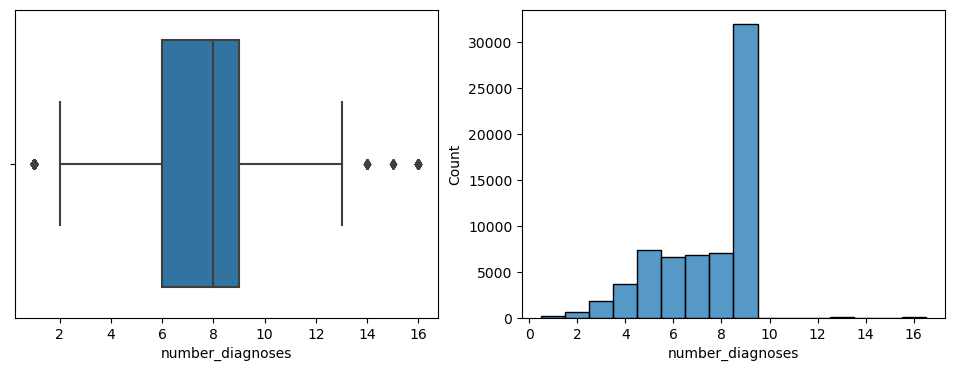

In [43]:
focused_variable = twoRace['number_diagnoses'].copy()
box_and_hist_int(focused_variable)

There is something interesting happening at 9.  It seems like it could be a result of data collection where most facilities included in the study only keep 9 diagnoses for an admission while a small number of other facilities allow more.  It could also be that a common type of admission among diabetics has a diagnoses set that includes 9 different codes.  If the second option is true, the diag_1, 2 and 3 variables should have common values for many of the observations with 9. 

In [44]:
nines = focused_variable == 9

only_9_dx = twoRace.loc[nines, ['diag_1','diag_2','diag_3']]
only_9_dx.value_counts().sort_values(ascending=False).head(10)

diag_1  diag_2  diag_3
414     411     428       74
584     276     276       63
414     411     427       51
428     425     427       48
414     411     250       44
410     428     427       41
38      599     276       40
486     491     428       38
414     411     401       38
428     403     585       37
dtype: int64

The 400 series codes are heart disase codes, 500s are kidney disease and 276 is a fluid imbalance, commonly seen with kidney disorders.  This has somewhat validated the theory that the 9s could be saved codesets, but this needs to be compared to the full dataset to verify.

In [45]:
twoRace[['diag_1','diag_2','diag_3']].value_counts().sort_values(ascending=False).head(10)

diag_1  diag_2  diag_3
414     411     250       216
                401       168
786     401     250       168
        250     401       158
410     414     250       143
715     401     250       136
414     401     250       118
715     250     401       116
414     250     401       114
        411     428       109
dtype: int64

At a glance, the top 3 diagnoses of the oberservations with 9 diagnoses are much different than the full set.  This lends more weight to the idea that they are saved codesets.  Are these top 3 diagnoses similar for observations that have 9 total diagnoses and more than 9?

In [46]:
more_than_nine = focused_variable > 9
more_than_nine = twoRace.loc[more_than_nine, ['diag_1','diag_2','diag_3']]
more_than_nine.value_counts().sort_values(ascending=False).head(10)

diag_1  diag_2  diag_3
157     415     199       1
403     585     250.8     1
250.4   425     276       1
250.8   458     V08       1
        518     707       1
250.82  707     682       1
276     486     599       1
        584     562       1
        785     585       1
283     574     250.02    1
dtype: int64

No, every observation with more than 9 diagnoses has different values for diagnoses 1-3.  What does this distribution look like if we apply the q3 + 1.5iqr rule to it?

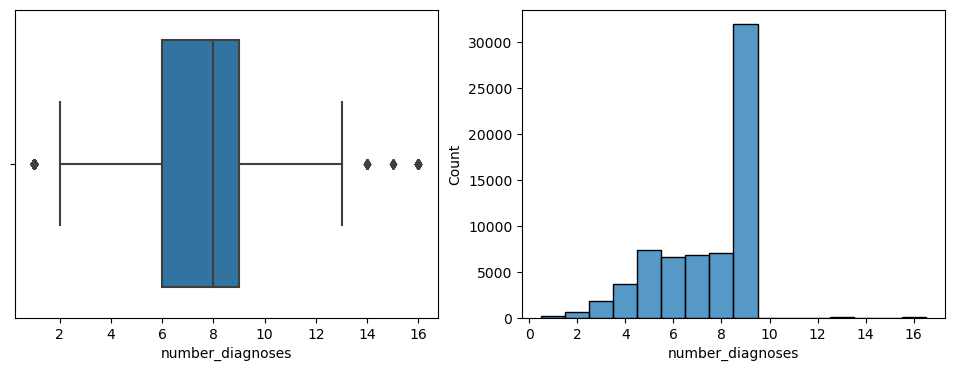

       number_diagnoses
count      66225.000000
mean           7.420385
std            1.925318
min            1.000000
25%            6.000000
50%            8.000000
75%            9.000000
max           16.000000


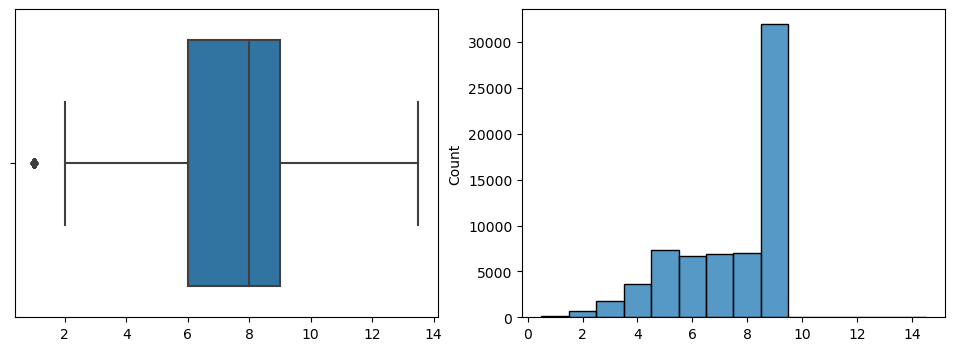

                  0
count  66225.000000
mean       7.419434
std        1.921738
min        1.000000
25%        6.000000
50%        8.000000
75%        9.000000
max       13.500000

right whisker value: 13.5


In [47]:
iqr_info(focused_variable)

This seems like an acceptable way to handle these outliers.

In [48]:
outer_whisker = np.percentile(focused_variable, 75) + 1.5 * (np.percentile(focused_variable, 75) - np.percentile(focused_variable, 25))
twoRace.number_diagnoses = np.where(focused_variable > outer_whisker, outer_whisker, focused_variable)

### diag_1-3<a id="dx"></a>

In [49]:
focused_variable = twoRace[['diag_1','diag_2','diag_3']].copy()

The top 3 diagnoses for the patient's admission will be the next target of this exploration.  These are stored as ICD9 codes that describe a patient's condition.  Knowing how much of each variable is missing or formatted incorrectly would be a good place to start with these.  CMS has a well defined [format](https://www.cms.gov/Medicare/Quality-Initiatives-Patient-Assessment-Instruments/HospitalQualityInits/Downloads/HospitalAppendix_F.pdf) for ICD9 codes.  This is also found in the references folder of this project.

In [50]:
def bad_icd_len(diags):
    diags = diags.astype(str)
    too_short = (diags.str.len() < 3).sum()
    too_long = (diags.str.len() > 6).sum()
    return(too_short, too_long)

[f'{dx}: {bad_icd_len(focused_variable[dx])}' for dx in focused_variable]

['diag_1: (1738, 0)', 'diag_2: (1306, 0)', 'diag_3: (1894, 0)']

All 3 diagnoses variables have values that are too short.  What do these look like?

In [51]:
{dx: focused_variable[dx][focused_variable[dx].str.len() < 3].sample(n=10) for dx in focused_variable}

{'diag_1': encounter_id
 154962672    79
 134785944    38
 20188626     38
 188046018    38
 354954188    38
 193820394    38
 269796240    38
 212953542    38
 67326456     42
 108723540     8
 Name: diag_1, dtype: object,
 'diag_2': encounter_id
 71022186     70
 106180584    38
 279893982    41
 38225280      ?
 53013012     38
 110516160    41
 249229662     8
 155541264    70
 11204994     34
 223146180    42
 Name: diag_2, dtype: object,
 'diag_3': encounter_id
 97266516     70
 38006994      ?
 329574596    41
 106942224     ?
 179921040     ?
 240689280    70
 8308146      70
 22788300      ?
 150989268    41
 214066392     ?
 Name: diag_3, dtype: object}

From these samples, there are 2 issues to address.

1. The leading 0 has been removed from the 000-099 series of codes.
2. Missing codes have a value of "?"

Issue 1 will be addressed first by padding the leading zeroes back onto the front of the codes.

In [52]:
for col in focused_variable.columns:
    focused_variable[col] = focused_variable[col].str.zfill(3)

I would like to explore using Word2Vec to create new features for the diag_x columns.  Missing values should not be included in the training.  I will create 1 sentence per observation that includes all non-missing values from diag_1-3.  In the interest of time, the vector size and workers will be based on my laptop's hardware.

In [53]:
fv_no_missing = focused_variable.replace('00?', np.nan).copy()
sentences = fv_no_missing.apply(lambda row: row.dropna().tolist(), axis=1).tolist()
model = Word2Vec(sentences, vector_size=500, window=2, min_count=1, workers=16)

A new continuous variable will be created and assigned the value of the median of the vectors assigned to each diagnosis word.  

In [54]:
def vec_dx(dx_list, model):
    dx_list = dx_list.tolist()
    vectors = [model.wv[dx] for dx in dx_list if dx in model.wv]
    return np.median(vectors)

fv_no_missing['3dx_vector'] = fv_no_missing[['diag_1','diag_2','diag_3']].apply(lambda row: vec_dx(row, model), axis=1)

The new variable containing the median of the vectors will then have k-means clustering applied to group each unique set of values of diag_1-3 into broader categories that are similar to each other.  The number of clusters was selected based on the highest silhouette score in a reasonable range.

In [55]:
vectors = np.array(fv_no_missing['3dx_vector'].tolist())
reshaped_vectors = vectors.reshape(-1, 1)

#min_clusters = 3
#max_clusters = 15
#silhouette_scores = []

#for n_clusters in range(min_clusters, max_clusters+1):
#    kmeans = KMeans(n_clusters=n_clusters)
#    cluster_labels = kmeans.fit_predict(reshaped_vectors)
#    sihouette_avg = silhouette_score(reshaped_vectors, cluster_labels)
#    silhouette_scores.append(sihouette_avg)
    
#plt.plot(range(min_clusters, max_clusters+1), silhouette_scores, marker='o')
#plt.xlabel("Number of Clusters")
#plt.ylabel("Silhouette Score")
#plt.title("Silhouette Analysis")
#plt.show()

In [56]:
kmeans = KMeans(n_clusters=9)
cluster_labels = kmeans.fit(reshaped_vectors)
cluster_labels = cluster_labels.labels_
fv_no_missing['dx_cluster'] =  cluster_labels
fv_no_missing

,diag_1,diag_2,diag_3,3dx_vector,dx_cluster
encounter_id,,,,,
64410,648,250,V27,-0.002332,3
28236,250.7,403,996,0.004136,1
36900,157,288,197,-0.006974,2
62256,518,998,627,0.000230,0
73578,999,507,996,0.001425,4
...,...,...,...,...,...
179844000,403,536,250,0.000797,0
274508874,515,799,466,0.002994,1
132023796,486,427,427,0.004295,1


This new feature represents groups of similar diagnoses in each admission.  It will replace diag_1-3.

In [57]:
twoRace['dx_cluster'] = fv_no_missing['dx_cluster']
twoRace = twoRace.drop(['diag_1','diag_2','diag_3'], axis=1)

The new feature should also be checked for correlation with one_lab_procedure

In [58]:
chi2pvalue(twoRace.one_lab_procedure, twoRace.dx_cluster)

1.2492324271396358e-16

It is safe to leave the new feature in place. 

### medications<a id="meds"></a>

The last set of features to explore are the features that represent whether a particular prescription was continued after the admission or had its dosage changed.  

In [59]:
focused_variable = twoRace[['metformin','repaglinide','nateglinide','chlorpropamide','glimepiride','glipizide', 
                            'glyburide','tolbutamide','pioglitazone','rosiglitazone','acarbose','miglitol', 
                            'tolazamide','insulin','glyburide-metformin']].copy()

for column in focused_variable.columns:
    unique_values = focused_variable[column].unique()
    print(f'{column}:')
    print(unique_values, '\n')    

metformin:
['No' 'Steady' 'Up' 'Down'] 

repaglinide:
['No' 'Steady' 'Up' 'Down'] 

nateglinide:
['No' 'Steady' 'Up' 'Down'] 

chlorpropamide:
['No' 'Steady' 'Up'] 

glimepiride:
['No' 'Steady' 'Down' 'Up'] 

glipizide:
['Steady' 'No' 'Up' 'Down'] 

glyburide:
['No' 'Up' 'Steady' 'Down'] 

tolbutamide:
['No' 'Steady'] 

pioglitazone:
['No' 'Steady' 'Down' 'Up'] 

rosiglitazone:
['No' 'Steady' 'Up' 'Down'] 

acarbose:
['No' 'Steady' 'Up' 'Down'] 

miglitol:
['No' 'Steady' 'Up' 'Down'] 

tolazamide:
['No' 'Steady' 'Up'] 

insulin:
['No' 'Steady' 'Up' 'Down'] 

glyburide-metformin:
['No' 'Steady' 'Down' 'Up'] 



It looks like the levels for these categorical features are 'No', 'Up', 'Steady', and 'Down'. Although there are 3 medications that don't have the complete set of values, they share some of this list and it can be inferred that these were possibilities during data collection. In most cases, the levels for these categorical features are 'No', 'Up', 'Steady', and 'Down'.  Although there are 3 medications that don't have the complete set of values, they share some of this list and it can be inferred that these were possibilities during data collection.

The glyburide-metformin combination could be redundant with the columns for the 2 individual drugs.  If they are redundant, the values across all 3 would match.  If they are not, the value of the combination would be populated (not 'No') and the value of the other 2 would not be (= 'No').  Is this what is happening?

In [60]:
gbmt = focused_variable[['metformin','glyburide','glyburide-metformin']]
gbmt[gbmt['glyburide-metformin'] != 'No'].groupby(['metformin','glyburide']).value_counts()

metformin  glyburide  glyburide-metformin
Down       Steady     Steady                   1
           Up         Steady                   1
No         Down       Steady                   1
           No         Steady                 360
                      Up                       5
                      Down                     2
           Steady     Steady                  15
           Up         Steady                   1
Steady     No         Steady                  22
           Steady     Steady                   6
           Up         Steady                   1
Up         No         Steady                   1
           Steady     Steady                   2
dtype: int64

For the majority of observations, this holds true.  It is possible for patients to have any combination of the prescriptions, but it should be rare.  That is what is seen here and no further action is needed on these variables.  

Next, the high dimenstionality of these variables needs to be addressed.  There are 15 potentially low value variables here.  Encoding these would yield at least 40 total.  Some dimensionality reduction is needed.  Drugs are often grouped into pharmaceutical classes.  Several of the drugs in this list share a pharmaceutical class.  These classes describe the intended effect of the drug on specific body systems.  Patients should not be taking more than one drug of a class.  Let's make sure this is mostly true for this data.  The pharm class data was pulled from [drugbank.com](https://go.drugbank.com/).

In [61]:
drug_classes = {
    'metformin': 'Biguanide',
    'repaglinide': 'Meglitinide',
    'nateglinide': 'Meglitinide',
    'chlorpropamide': 'Sulfonylurea',
    'glimepiride': 'Sulfonylurea',
    'glipizide': 'Sulfonylurea',
    'glyburide': 'Sulfonylurea',
    'tolbutamide': 'Sulfonylurea',    
    'pioglitazone': 'Thiazolidinedione',
    'rosiglitazone': 'Thiazolidinedione',
    'acarbose': 'Alpha-glucosidase inhibitor',
    'miglitol': 'Alpha-glucosidase inhibitor',
    'tolazamide': 'Sulfonylurea',
    'insulin': 'Hormone',
    'glyburide-metformin': 'Combination medication (Sulfonylurea + Biguanide)'
}

multi_drug_classes = {
    'repaglinide': 'Meglitinide',
    'nateglinide': 'Meglitinide',
    'chlorpropamide': 'Sulfonylurea',
    'glimepiride': 'Sulfonylurea',
    'glipizide': 'Sulfonylurea',
    'glyburide': 'Sulfonylurea',
    'tolbutamide': 'Sulfonylurea',    
    'pioglitazone': 'Thiazolidinedione',
    'rosiglitazone': 'Thiazolidinedione',
    'acarbose': 'Alpha-glucosidase inhibitor',
    'miglitol': 'Alpha-glucosidase inhibitor',
    'tolazamide': 'Sulfonylurea'
}

multi_class_locs = []
fv_just_mult = focused_variable[list(multi_drug_classes.keys())]

for index, row in fv_just_mult.iterrows():
    count_by_class = {}
    not_no_count = 0

    for drug, class_name in multi_drug_classes.items():
        value = row[drug]
        if value != "No":
            not_no_count += 1
            count_by_class[class_name] = count_by_class.get(class_name, 0) + 1

    if not_no_count >= 2 and max(count_by_class.values()) >= 2:
        multi_class_locs.append(index)

multi_class_obs = fv_just_mult.loc[multi_class_locs]
fv_just_mult.loc[multi_class_locs]

,repaglinide,nateglinide,chlorpropamide,glimepiride,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,tolazamide
encounter_id,,,,,,,,,,,,
8688120,No,No,No,Steady,Steady,Steady,No,No,No,No,No,No
9459792,No,No,No,Up,Steady,No,No,No,No,No,No,No
9808008,No,No,No,No,Up,Steady,No,No,No,No,No,No
11081784,No,No,No,No,Steady,Steady,No,No,No,No,No,No
22051944,No,No,No,No,Steady,Steady,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...
125525730,No,No,No,Steady,Steady,No,No,Steady,No,No,No,No
383781080,No,No,No,No,Steady,No,No,Steady,Steady,No,No,No
199516566,No,No,No,No,No,No,No,Steady,Steady,No,No,No


As expected, this case is rare.  Each of the combinations here involve holding one drug (or more than one from the class) steady and increasing the other.  The net effect of this is that the class was increased.  A new feature with the class name would be "Up".  This creates a problem if any of these observations have "Up" and "Down" in the same class.

In [62]:
problem_indexes = []

for index, row in multi_class_obs.iterrows():
    class_counts = {}
    for drug, class_name in multi_drug_classes.items():
        if row[drug] != 'No':
            if class_name not in class_counts:
                class_counts[class_name] = set()
            class_counts[class_name].add(row[drug])

    for class_name, drug_values in class_counts.items():
        if 'Up' in drug_values and 'Down' in drug_values:
            problem_indexes.append(index)

multi_class_obs.loc[problem_indexes]

,repaglinide,nateglinide,chlorpropamide,glimepiride,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,tolazamide
encounter_id,,,,,,,,,,,,
98734140,No,No,No,Down,No,Up,No,No,No,No,No,No


The 1 encounter that meets this criteria can be dropped.

In [63]:
print(twoRace.shape)
twoRace = twoRace.drop(index=problem_indexes)
focused_variable = focused_variable.drop(index=problem_indexes)
print(twoRace.shape)

(66225, 36)
(66224, 36)


In [64]:
def collapse_columns(row):
    if 'Up' in row.values:
        return 'Up'
    elif 'Down' in row.values:
        return 'Down'
    elif 'Steady' in row.values:
        return 'Steady'
    else:
        return 'No'

def combine_classes(drug_class):
    drugs = [key for key, value in multi_drug_classes.items() if value == drug_class]
    rows = focused_variable[drugs].copy()
    values = rows.apply(collapse_columns, axis=1)
    drug_class += '_class'
    focused_variable[drug_class] = values

classes = list(set(multi_drug_classes.values()))
for drug_class in classes:
    combine_classes(drug_class)

focused_variable


,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,tolazamide,insulin,glyburide-metformin,Sulfonylurea_class,Thiazolidinedione_class,Alpha-glucosidase inhibitor_class,Meglitinide_class
encounter_id,,,,,,,,,,,,,,,,,,,
64410,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,Steady,No,No,No
28236,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No
36900,No,No,No,No,No,No,Up,No,No,No,No,No,No,Steady,No,Up,No,No,No
62256,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No
73578,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179844000,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No
274508874,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No
132023796,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Steady,No,No


In [65]:
to_drop = [col for col in focused_variable.columns if not col.endswith('_class')]
focused_variable = focused_variable.drop(to_drop, axis=1)
twoRace = twoRace.drop(to_drop, axis=1)
twoRace = twoRace.merge(focused_variable, left_index=True, right_index=True)

### Wrap-Up<a id="wrapUp"></a>

The exploratory analysis is complete.  In a high level review, the changes made are:

- corrected for race bias
- added a new feature 'DischargedToCare'
- removed